In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
import sys
import os

basedrive = "drive/My Drive/upper limb use assessment"
os.chdir(basedrive)
sys.path.append("scripts")

In [4]:
!pip install ahrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.2 MB/s 


In [5]:
!pip install scikit-learn==0.23

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.3 MB 4.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.0 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.0 which is incompatible.


In [6]:
!pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [140]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import signal

In [8]:
l, r = ca.read_data('control')
aff, unaff = ca.read_data('patient')

# Pitch

In [285]:
def compute_tilt(ax, freq):
  w = round(freq)
  ax = np.append(np.ones(w-1)*ax[0], ax)

  # moving average filter
  ax = np.convolve(ax, np.ones(w), 'valid') / w

  ax[ax<-1] = -1
  ax[ax>1] = 1
  return -np.rad2deg(np.arccos(ax))+90

In [286]:
ax = r[r.subject==1].ax.values
pitch_hat = compute_tilt(ax, 50)
pitch = r[r.subject==1].pitch.values

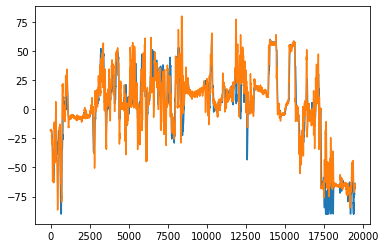

In [287]:
plt.plot(pitch_hat)
plt.plot(pitch)

Text(0, 0.5, 'pitch')

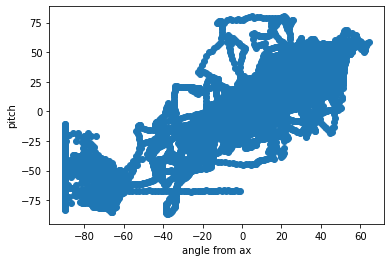

In [349]:
plt.scatter(pitch_hat, pitch)
plt.xlabel('angle from ax')
plt.ylabel('pitch')

In [289]:
pearsonr(pitch, pitch_hat)

(0.9046985706407787, 0.0)

# Activity counts

In [290]:
counts = (ca.compute_vector_magnitude(r[r.subject==1])).counts.values
ay = r[r.subject==1].ay
az = r[r.subject==1].az

In [335]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

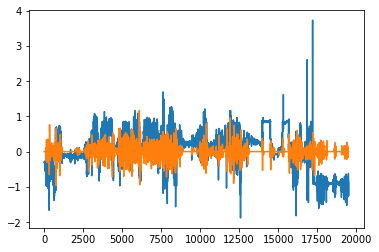

In [336]:
plt.plot(ax)
plt.plot(ax_filt)

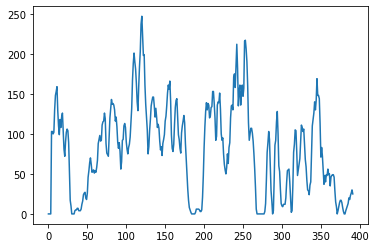

In [337]:
plt.plot(counts)

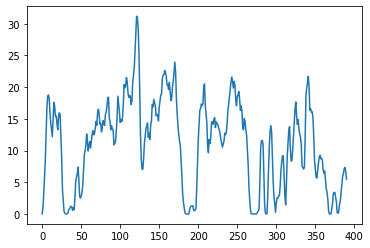

In [338]:
plt.plot(amag)

In [339]:
counts[np.isnan(counts)] = 0

Text(0, 0.5, 'counts')

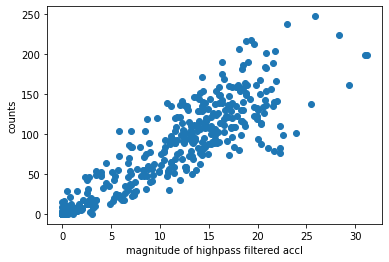

In [348]:
plt.scatter(amag, counts[1:])
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [341]:
pearsonr(amag, counts[1:])

(0.8822045564601536, 2.618118077333752e-129)

# GMAC

In [342]:
gmac = [1 if np.abs(pitch) < 30 and count > 0 else 0 for pitch, count in zip(pitch_hat, amag)]
gnd = [r[r.subject==1].gnd[i] for i in range(0, len(r[r.subject==1]), 50)]

In [343]:
ca.confmatrix(gmac, gnd)

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.368286,0.089514,0.381074,0.161125,0.529412,0.097553,0.491468,0.642857,0.804469,0.610169,0.567162


In [344]:
gmac_original = (ca.get_gm_modified(r[r.subject==1])).pred.values

In [345]:
ca.confmatrix(gmac_original, gnd[1:])

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.54359,0.110256,0.207692,0.138462,0.682051,0.453757,0.723549,0.556701,0.831373,0.773723,0.640125


In [346]:
np.column_stack((gnd, gmac, np.append(0, gmac_original)))

array([[0, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [303]:
pitch_hat

array([-17.50453284, -17.51216007, -17.52154786, ..., -64.04789218,
       -63.99041558, -63.82249496])

In [304]:
pitch

array([-18.00087546, -18.04223279, -18.17406684, ..., -64.73383036,
       -65.37888202, -65.79471114])

In [306]:
counts

array([  0.,   0.,   0.,   0., 103., 103., 100., 102., 130., 148., 153.,
       159., 129., 110.,  99., 118., 108., 121., 126., 105.,  81.,  72.,
        90., 102., 106., 104.,  89.,  53.,  17.,  10.,   0.,   0.,   0.,
         0.,   4.,   5.,   5.,   7.,   7.,   4.,   4.,   4.,   6.,  12.,
        16.,  24.,  26.,  27.,  20.,  18.,  26.,  46.,  54.,  64.,  70.,
        62.,  52.,  54.,  55.,  51.,  54.,  52.,  58.,  67.,  88.,  93.,
        98.,  91.,  92., 111., 115., 116., 126., 119.,  88.,  76.,  74.,
        72.,  95., 120., 131., 143., 137., 138., 136., 130., 116., 121.,
       109.,  90.,  82.,  89.,  78.,  56.,  65.,  92.,  93., 110., 113.,
       108.,  90.,  81.,  75.,  83.,  87.,  96., 114., 132., 167., 188.,
       201., 190., 181., 163., 140., 129., 159., 184., 203., 237., 247.,
       224., 198., 199., 161., 137., 122., 105.,  75.,  84., 104., 118.,
       135., 141., 146., 146., 135., 121., 132., 121., 108., 112., 107.,
        91.,  80.,  84.,  73.,  88.,  93.,  99., 11

In [305]:
amag

array([ 0.14459262,  2.1839492 ,  5.2803897 ,  8.88063492, 13.07741808,
       18.45306616, 23.42920824, 24.62833428, 23.57817685, 22.33445107,
       19.36390375, 17.6875684 , 17.14938484, 17.59410178, 22.42218024,
       25.21270062, 22.47561743, 20.86376369, 20.84154065, 18.21282555,
       18.80433915, 20.69459821, 20.79469609, 18.81114448, 14.23674543,
        8.81017418,  4.28891648,  2.01437083,  1.14337383,  0.89783687,
        1.28700013,  1.80557951,  3.27472219,  4.31524083,  5.03609948,
        4.96693813,  5.29451146,  4.20100225,  3.39425764,  3.89826352,
        4.13858085,  4.55380472,  8.22309831,  9.78124847,  9.28974318,
       10.12211934, 10.30319765,  7.21772537,  6.4991869 ,  7.26749773,
        8.08843055,  7.86262273,  8.62624994, 11.56880276, 13.50727204,
       13.14817057, 16.45153597, 16.58162214, 13.57574511, 12.02523245,
       14.20380266, 13.1311533 , 13.92946307, 16.88172435, 18.40936363,
       17.88412967, 17.75709463, 19.02498465, 18.74207059, 19.09